# Домашнее задание 3

В этом домашнем задании мы рассмотрим практическое применение модели SARIMA. 

Эта модель - самый универсальный базовый инструмент. Если вы не знаете, с чего начать, то это будет хорошим бейзлайном. Если у вас при этом ещё и мало данных, то скорее всего она будет чуть ли не единственным адекватным вариантом наряду с ETS. 


# 1. SARIMA как независимая модель

Для начала попробуем применить модель как самостоятельную на очень простых данных. Возьмём стандартный датасет квартальных данных по макроэкономике США и выберем из него ряд численности населения.

In [1]:
from sktime.datasets import load_macroeconomic
import pandas as pd 

data = load_macroeconomic()
data.index = pd.date_range(start = '01.01.1959', periods = len(data), freq='Q')
data = data['pop']

Исходя из описания на сайте statsmodels, он представляет собой численность населения США на конец каждого квартала с учётом всех вооружённых сил, находящихся за рубежом.

Для начала вспомним структуру модели. Она представлена на картинке. Нотация B (Backshift) эквивалентна оператору лага. Период сезонности равен четырём.

![Alt text](sarima_scheme.png)

Разберём ещё раз подробно параметры и как их подбирать.
$$SARIMA(p,d,q)(P,D,Q)$$

Начнём с базовых.

- p - порядок авторегрессии
- d - порядок интеграции
- q - порядок скользящего среднего

Когда мы говорили про ARIMA-модель на семинарах, мы обсуждали, что для каждого из них есть свой паттерн поведения автокорреляций:

- Для выбора параметра d мы используем тесты на стационарность. Также нестационарность можно видеть по характерному рисунку автокорреляций: ACF очень (иногда и не очень) медленно убывает, а из PACF очень значима первая, а остальные близки к нулю.
- Для AR(p)-процесса частные автокорреляции обрываются на лаге p
- Для MA(q)-процесса автокорреляции обрываются на лаге q
- Для ARMA(p,q) обе убывают и обычно на практике просто перебирают все комбинации, ограничивая границы перебора максимально значимым порядком автокорреляций.

Сезонные параметры подбираются очень похожим способом. Так как SARIMA - модель с одним периодом сезонности, зафиксируем его. Предположим, что у нас месячные данные и, соответственно, месячная сезонность.

- Если в нашем процессе сезонность представлена авторегрессией порядка P, то автокорреляции сезонных лагов (т.е. каждого 12-го лага) экспоненциально убывают, а частные автокорреляции сезонных лагов обрываются на порядке P.

- Если в нашем процессе сезонность представлена скользящим средним порядка Q, то автокорреляции сезонных лагов (т.е. каждого 12-го лага) обрываются на порядке Q, а частные автокорреляции сезонных лагов экспоненциально убывают.

То есть на самом деле, подход вообще не поменялся, и мы просто смотрим не на каждый лаг, а на каждый k-й лаг

Про параметр D пока что осознанно умолчим, о нём чуть ниже.

### 1.0 (0 баллов)

Разделите ряд на тренировочную и тестовую выборку, в качестве теста возьмите 20% последних наблюдений. Весь анализ производим на тренировочной выборке.

In [3]:
# ༼ つ ◕_◕ ༽つ

### 1.1 (0.5 балла)
Визуализируйте этот ряд, его автокорреляции и частные автокорреляции. Присутствуют ли в нём тренд и сезонность? 

In [ ]:
# ༼ つ ◕_◕ ༽つ

### 1.2 (0.5 балла)

Выясните порядок интеграции ряда (aka параметр d) c помощью KPSS-теста. Нарисуйте коррелограммы стационарной версии ряда.

In [ ]:
# ༼ つ ◕_◕ ༽つ

### 1.3 (0.5 балла)

По графикам автокорреляций из предыдущего пунтка подберите значения (или по крайней мере границы значений) параметров p, q, P, Q. Обязательно аргументируйте выбор каждого параметра. Без аргументации пункт не засчитывается.

In [ ]:
# ༼ つ ◕_◕ ༽つ

### Длинное лирическое отступление

На самом деле для рядов с сильной сезонностью можно производить отбор несколько по-другому и сэкономить пару параметров. Для этого начнём подбор не с параметра d, а с параметра D. 

Возникает первый вопрос. А что такое вообще "сильная" сезонность? Мы помним, что из STL-разложения можно подсчитать силу сезонности, но с каким порогом её сравнивать? В основном, пользуются эмпирической константой 0.65. Если сила сезонности больше неё, то сезонность считается сильной. В этом случае обычно пытаются однократно применить сезонные разности, что соответствует D=1. 

Сезонная разность порядка 12, например, выражается следующим образом:
$$ \Delta y^{12}_t = y_t - y_{t-12}$$

Притом важно обратить внимание, что сезонная разность выполняет двойную функцию.

Во-первых, она стандартным уменьшает порядок интеграции на единицу.

Во-вторых, она фильтрует значительную часть сезонных автокорреляций. Здесь логика абсолютно такая же, как с обычными автокорреляциями и трендами. Если привести ряд к стационарному, картина автокорреляций становится более очевидной. Вот и с сезонными лагами ситукция такая же. То есть взятие сезонных разностей может сократить количество необходимых сезонных коэффициентов

Так как сила сезонности после взятия разности уже почти наверное не будет высокой, на практике D=2 никогда не возникает. Если же после взятия сезонных разностей ряд всё ещё остаётся нестационарным, то можно дополнительно взять несколько раз обычные разности по стандартной процедуре. 

Теперь вернёмся к исходным данным и попробуем повторить подбор параметров.

### 1.4 (0.5 балла)

Подберите параметр D, а затем параметр d. Нарисуйте коррелограммы стационарной версии ряда.

In [4]:
# ༼ つ ◕_◕ ༽つ

### 1.5 (0.5 балла)

По графикам автокорреляций из предыдущего пунтка подберите значения (или по крайней мере границы значений) параметров p, q, P, Q. Стал ли выбор параметров проще и очевиднее? Обязательно аргументируйте выбор каждого параметра. Без аргументации пункт не засчитывается.

In [5]:
# ༼ つ ◕_◕ ༽つ

### 1.6 (0.5 балла)

Сравните на кросс-валидации две полученных модели и модель, выбранную автоматическим алгоритмом. Скорее всего результаты моделей будут примерно эквивалентны. Горизонт прогнозирования: 12 месяцев.

In [6]:
# ༼ つ ◕_◕ ༽つ

### 1.7 (0.5 балла)

Постройте прогнозы трёх моделей на тестовый период и визуализируйте их на графике вместе с тестовыми данными. Желательно ещё на графике захватывать несколько лет трейна. Почему-то в прошлых дз почти никто так не делал, но это довольно неплохо помогает визуально оценивать адекватность прогнозов.

In [ ]:
# ༼ つ ◕_◕ ༽つ

# 1. VAR-модель

В этом разделе нам необходимо построить прогнозные модели для курсов валют. На семинарах мы обсуждали, что прогнозировать цены котировок стандартными линейными моделями довольно бесперспективно. Так как такие данные близки к модели случайного блуждания, оптимальным прогнозом для них часто оказывается наивный. Однако если перейти к более низкой частоте (например, к месячным данным), то некоторого превосходства над наивной всё же можно добиться.

В приложенном датасете находятся следующие величины:
1.  Курсы ряда валют по отношению к доллару. 

    Курс EUR/USD - Евро Доллар США
    
    Курс CNY/USD - Китайский юань Доллар США
    
    Курс INR/USD - Индийская рупия Доллар США
    
    Курс JPY/USD - Японская йена Доллар США
    
    Курс GBR/USD - Британский фунт Доллар США
    
    Курс CHF/USD - Швейцарский франк Доллар США
    
    Курс BRL/USD - Бразильский реал Доллар США
    
    Курс IDR/USD - Индонезийская рупия Доллар США

2. Цена нефти BRENT за баррель и цена газа в Европе за mmbtu (Британская тепловая единица)
3. ff_rate -- ставка ФРС США

Нашей задачей будет построить прогнозную модель для всех курсов валют из пункта 1. Цены нефти, газа и ставка ФРС даны дополнительно, можете использовать их если посчитаете необходимым, но в базовой версии можно использовать только временные ряды курсов валют.

### Импорт данных

Импортируйте данные из файла. Приведите информацию о датах в один столбец типа datetime. Например, чтобы каждая точка отображала дату начала месяца. 

In [4]:
import pandas as pd
data = pd.read_csv("currencies.csv", sep=";", decimal=',').astype(float)
data.head()
data = data.rename(columns={"Год":"year", "Месяц": "month"}).drop(columns=['Квартал'])
data['day'] = 1
data.index = pd.to_datetime(data.loc[:, ['year', "month", "day"]])
data = data.drop(columns=['year', "month", "day"])

currencies = ['eur_usd', 'cny_usd', 'inr_usd', 'jpy_usd', 'gbr_usd', 'chf_usd', 'brl_usd', 'idr_usd']

data = data.loc[:, currencies]

In [3]:
data = ...

Начнём с простой идеи. Если есть много рядов, то можно просто построить на каждый ряд модель.

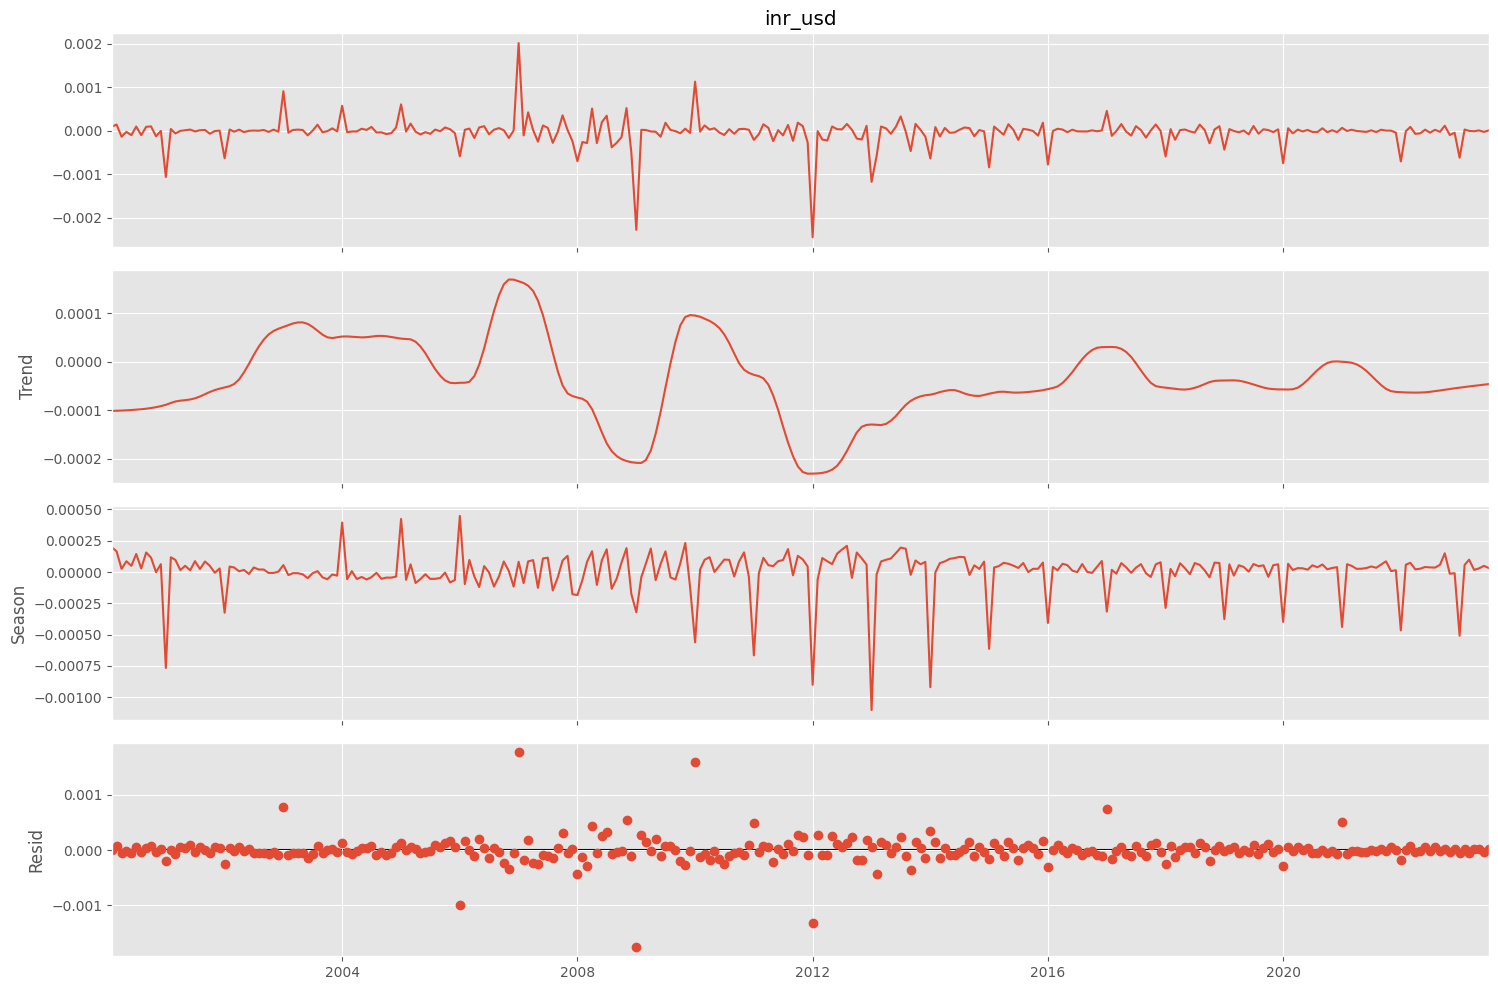

In [32]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(data.loc[:,'inr_usd'].diff().dropna(), period=12)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

In [34]:
data

,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd
2000-01-01,1.013610,0.120784,0.022243,0.949539,1.640095,0.629500,0.554614,0.000137
2000-02-01,0.984514,0.120801,0.022340,0.913322,1.601462,0.612571,0.563276,0.000135
2000-03-01,0.965026,0.120794,0.022483,0.940342,1.581504,0.601583,0.574004,0.000134
2000-04-01,0.945325,0.120783,0.022347,0.946392,1.581220,0.601190,0.565205,0.000128
2000-05-01,0.908461,0.120801,0.022323,0.924374,1.509061,0.583104,0.547661,0.000120
...,...,...,...,...,...,...,...,...
2023-03-01,1.071061,0.145039,0.012120,0.748226,1.214527,1.080700,0.192174,0.000065
2023-04-01,1.096370,0.145155,0.012110,0.749125,1.245177,1.113580,0.199370,0.000067
2023-05-01,1.086113,0.143078,0.012118,0.728717,1.248080,1.114409,0.200783,0.000067
2023-06-01,1.084395,0.139595,0.012094,0.707077,1.263834,1.111168,0.206236,0.000067


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='inr_usd'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

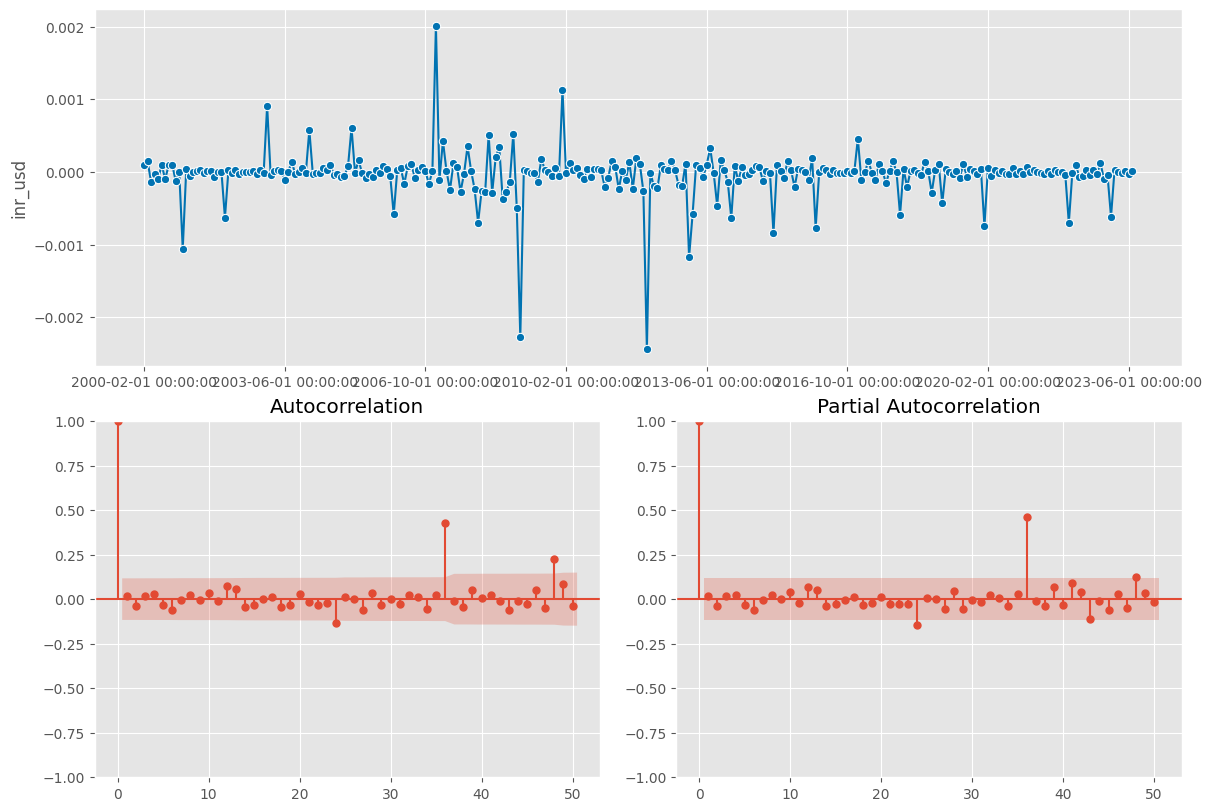

In [33]:
from sktime.utils.plotting import plot_correlations
plot_correlations(data.loc[:,'inr_usd'].diff().dropna(), lags = 50 )

Писать для каждого ряда одномерную модель несколько расточительно, хотя и не лишено смысла. Этот процесс необходимо автоматизировать. В простом для понимания варианте можно свести прогноз каждой валюты к табличной задаче и подобрать регрессоры из остальных рядов. Мы попробуем зайти с немного другой стороны.

Весь рынок и в частности рынок валют -- единый механизм, находящийся в некотором равновесии и иногда от него отклоняющийся. Значит, у рядов должен быть общий тренд. Формально такая ситуация называется коинтеграцией и это тема отдельной лекции, нам он будет нужен только для идеи. Более подробно про коинтеграцию можно почитать вот в этом [конспекте](https://vk.com/doc126754362_567660819?hash=AvDGHaO92KX7exjBCleLZsEGHPPX2iZfCqae2Fijkng). 

Задание 1.
Давайте увидим это явно. Возьмите все курсы валют, отнормируйте их c помощью StandardScaler из sklearn и изобразите результат на одном графике. Да, он немного шумный, но вы должны заметить что в целом валюты движутся по схожим траекториям, а некоторые группируются.

Давайте построим отдельную многомерную модель для каждого ряда Мы проходили только VAR(p) из прогнозирующих моделей, но её достаточно в большинстве случаев. Также мы обсуждали, что количество параметров в VAR(p)-модели равно 

$$n^2 p + n + \frac{n(n+1)}{2},$$

где n число уравнений системы. Данное выражение растёт квадратично по n. Значит, количество уравнений нам бы хотелось минимизировать. У нас в наличии 8 валют и ещё потенциально 3 дополнительных переменных. Это слишком много для одной модели, необходимо сократить размерность.

Конечно, для временных рядов существуют специфические методы понижения размерности, но они выходят за рамки нашего курса. Поэтому мы воспользуемся не слишком подходящим, но зато простым и знакомым методом главных компонент (PCA). PCA никак не учитывает временную зависимость точек, но мы позволим себе пренебречь этим.

Примените PCA на рядах из восьми валют и отберите три первые главные компоненты. Изобразите их на одном графике. Сравните с предыдущим графиком. Компоненты будут примерно похожи на тренды нескольких разных групп валют.


### Модель для одной валюты

Построим модель для одной конкретной валюты, курса Евро к доллару. Дальнейшие шаги необходимо будет сделать для каждой из валют в списке, поэтому рекомендуется заранее писать код так, чтобы его было легко встроить в цикл. Например, разбивать код на функции и т.п.

Выберите набор рядов, которые будут служить признаками для курса евро. Включите в него все оставшиеся валюты, а также опционально переменные из дополнительного списка. Этот набор данных будет отражать весь остальной рынок кроме курса евро. 

Вычислите первые три компоненты на выбранных рядах.

In [9]:
import numpy as np
from sklearn.decomposition import PCA
X = data
pca = PCA(n_components=0.95)
pca.fit(X)

transformed_data = pca.fit_transform(X.drop(columns=['eur_usd']))

transformed_data = pd.DataFrame(transformed_data, columns=[f'component_{i+1}' for i in range(pca.n_components_)], index = X.index)

In [ ]:
transformed_data = ...

Склейте временной ряд курса евро и три получившихся компоненты PCA в один датасет

In [10]:
transformed_data["eur_usd"] = data["eur_usd"]

Оцените на полученном датасете VAR(p)-модель. Отбирать параметр p можно автоматически, с помощью BIC. 

Важное замечание. По-хорошему нужно оценивать модель на стационарных данных. Если бы мы оценивали модель методом максимального правдоподобия с ограничениями на стационарность, то ничего хорошего бы не вышло, коэффициенты бы сели на границу этого ограничения. Но так как в питоне (да и в целом чаще всего) модель оценивается методом наименьших квадратов, это можно проигнорировать. Для прогнозирования особой разницы не будет, но часть статистических тестов работать перестанет.

In [20]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
# make a VAR model
model = VAR(transformed_data)


results: VARResults = model.fit(5, ic="bic")
results.summary()

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Apr, 2024
Time:                     13:55:40
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.2790
Nobs:                     281.000    HQIC:                  -31.5582
Log likelihood:           2901.31    FPE:                1.63414e-14
AIC:                     -31.7452    Det(Omega_mle):     1.44053e-14
--------------------------------------------------------------------
Results for equation component_1
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.016140         0.031792           -0.508           0.612
L1.component_1         1.272377         0.087495           14.542           0.000
L1.component_2        -0.112363         0.088318  

Постройте прогноз на 12 шагов вперёд. Можно подглядеть в [документацию](https://www.statsmodels.org/dev/vector_ar.html#forecasting). Нам понадобится только прогноз для ряда курса, то есть один из четырёх рядов.

In [21]:
lag_order = results.k_ar
results.forecast(transformed_data.values[-lag_order:], 5)

array([[-0.38290367, -0.04127413, -0.18781286,  1.10650176],
       [-0.38336724, -0.04363965, -0.18976927,  1.10705478],
       [-0.3839414 , -0.04555475, -0.19145271,  1.1079314 ],
       [-0.3843786 , -0.04720889, -0.19309423,  1.10898528],
       [-0.38470628, -0.04870318, -0.19470306,  1.11011002]])

Постройте прогноз наивной модели на тот же период

Аналогично простройте прогнозы VAR-модели и наивной для всех остальных валют

Постройте следующий линейный график. Одна линия обозначает одну валюту

1.  По оси абсцисс идёт горизонт прогнозирования (от 1 до 12)
2.  По оси ординат отношение ошибки VAR-модели к ошибке наивной модели

Можно строить любой другой график кроме линейного, если он будет более интерпретируем. Простор для творчества!

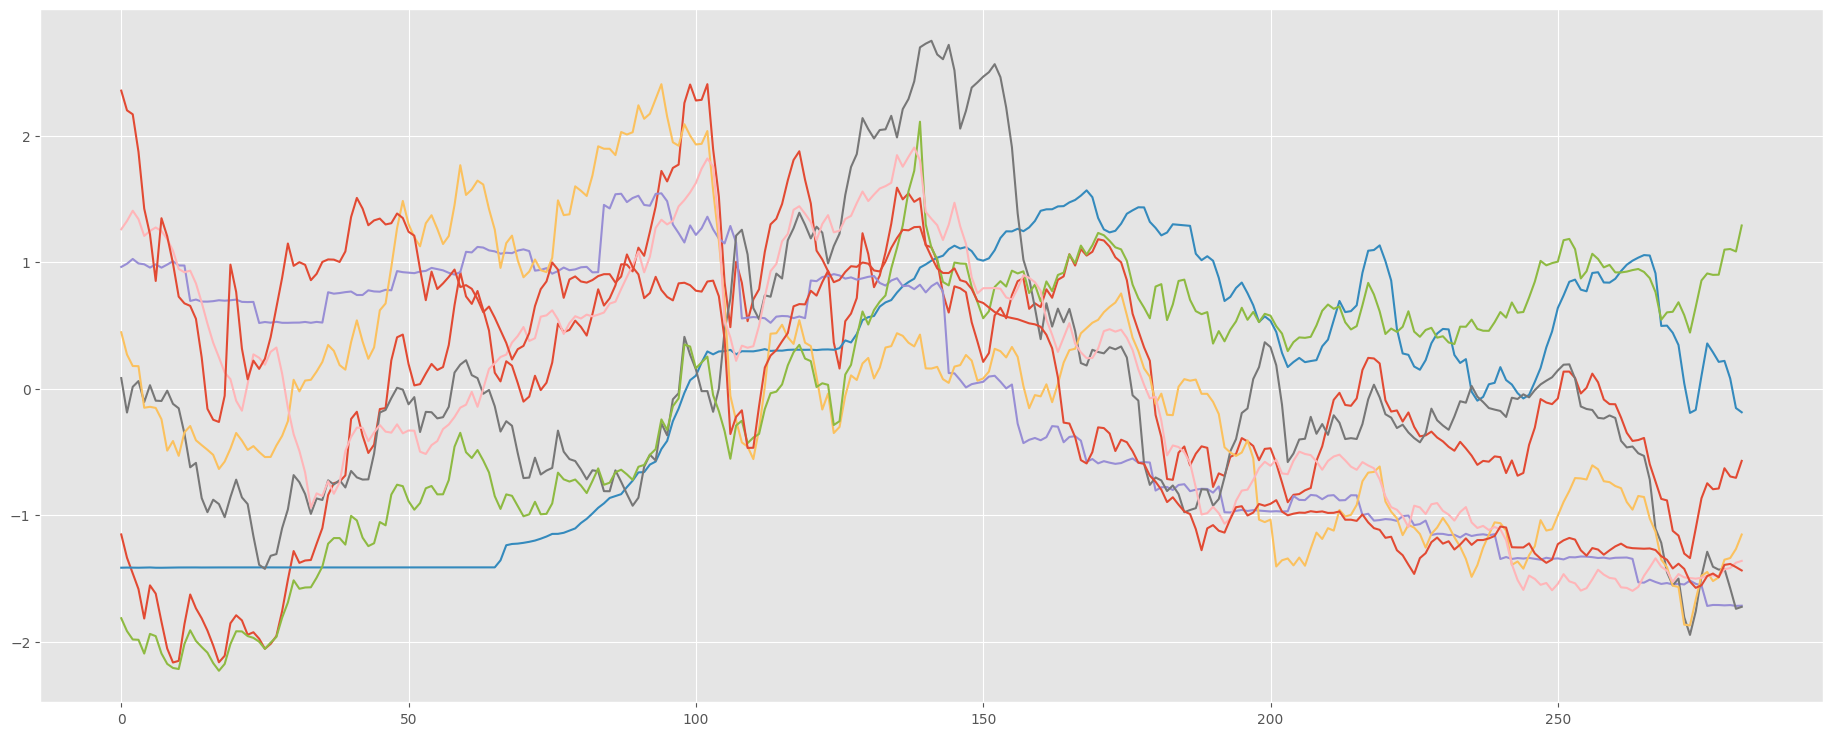

In [57]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()

plt.plot(scaler.fit_transform(data))

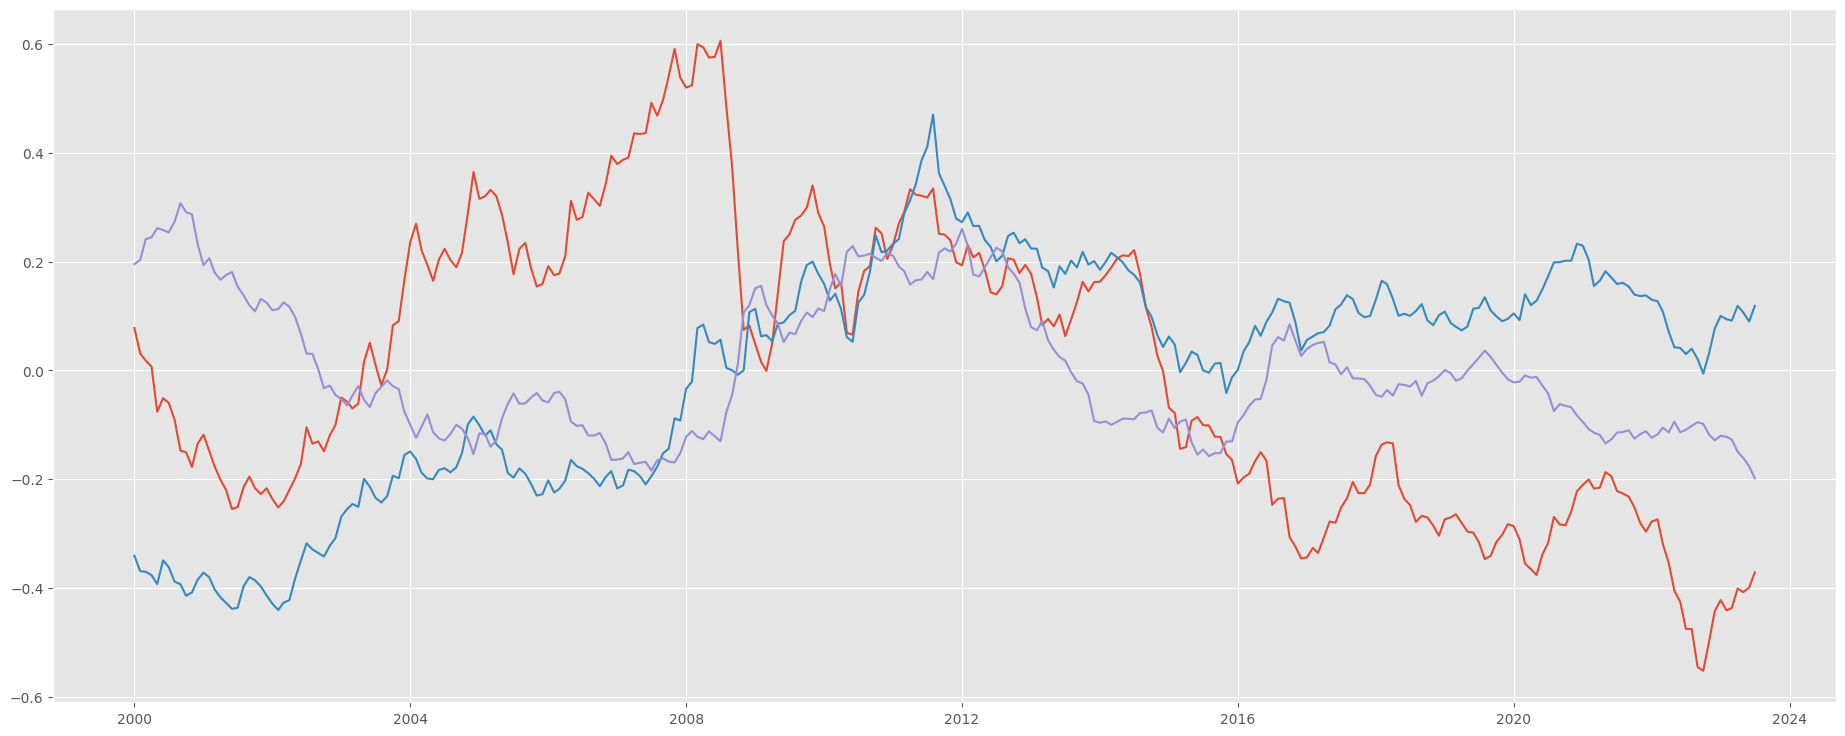

In [62]:
plt.plot(transformed_data, label="PCA")

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7